In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.externals import joblib

# due to the inherent stochasticity of the random forest model and
# data training and splitting we fix the random_state of all 
# objects that have random states with this parameter
random_state = 42

def cramers_v(chi, k, n):
    """
    calculates cramers v effect size for chisquare statistic
    
    V = sqrt( [chi^2/n]/[k - 1] )
    
    chi : chi square statistic
    n   : number of observations
    k   : number of features
    """
    return np.sqrt((chi/n)/(k-1))

def phi_coefficient(chi, n):
    """
    calculates the phi coefficient for the chisquare statistic
    
    phi = chi2/n
    """
    return chi/n

def split_continuous_data(data, split):
    if data < split:
        return 1
    else:
        return 0
    
def reduce_grade_density(grade):
    """
    Changes the grades from 0.0-4.0,T to low, high, T
    """
    if grade in ['0.0', '1.0', '1.5', '2.0', '2.5', '3.0']:
        return 'low'
    elif grade in ['3.5', '4.0']:
        return 'high'
    elif grade == 'T':
        return 'transfer'
    else:
        return np.nan
    
def is_white_asian(ethn):
    white_asian = ['Caucasian (non Hispanic)', 'Asian / Pacific Islander','Asian',]
    if ethn in white_asian:
        return 1
    else:
        return 0

def is_science_engineer(category):
    if category=='engineering':
        return category
    else:
        return 'other'

def is_physics(dept_name):
    if dept_name=='Physics-Astronomy':
        return True
    else:
        return None
    
def pred_category_number(category):
    if category=='other':
        return 0
    elif category=='engineering':
        return 1
    elif category=='physics':
        return 2
    else:
        raise ValueError('there isnt any category here.')

# the data set is produced by the following SQL query

    USE msu_db
    GO

    DECLARE @phys215 TABLE (id varchar(9), ones int)

    INSERT INTO @phys215
    SELECT  [student_id_fk]
      , 1
      FROM [msu_db].[dbo].[Courses] AS c
      WHERE c.Subj_Code = 'PHY'
      AND c.Crse_Code = '215'

      DECLARE @phys_declared TABLE (student_id_fk varchar(9), max_date datetime, declared int)

    INSERT INTO @phys_declared
    SELECT  [student_id_fk]
          ,MAX([term_timestamp])
          ,CASE WHEN dept_name = 'Physics-Astronomy' THEN 1
                ELSE 0 
          END AS [phys-chem-declared]
      FROM [msu_db].[dbo].[Majors]
      WHERE Student_Level_Code = 'UN'
      AND graduated IS NULL
      AND dept_name IN ('Physics-Astronomy')--, 'Mathematics', 'Chemistry')

      GROUP BY student_id_fk, dept_name

      DECLARE @physgrads TABLE (student_id_fk varchar(9), grad_date datetime, phys_grad int)
    INSERT INTO @physgrads
    SELECT DISTINCT [student_id_fk]
          ,MAX([term_timestamp]) as [grad date]
          ,CASE WHEN dept_name = 'Physics-Astronomy' THEN 1
                ELSE 0 
                END AS [phys-chem-grad]
      FROM [msu_db].[dbo].[Majors]
      WHERE Student_Level_Code = 'UN'
      AND dept_name IN ('Physics-Astronomy')
      AND graduated = 'CONF'

      GROUP BY student_id_fk, dept_name

      DECLARE @engphys TABLE (student_id_fk varchar(9), engtook int)
    INSERT INTO @engphys
    SELECT DISTINCT m.student_id_fk
    , 1 AS [took engineering as physics major]

    FROM Majors AS m
    JOIN Courses AS c
    ON m.student_id_fk = c.student_id_fk
    AND m.term_code = c.Term_Code

    WHERE dept_name IN ('Physics-Astronomy')
    AND c.Student_Level_Code = 'UN'
    AND Subj_Code IN ('ECE', 'CE', 'ENE', 'CHE', 'CSE', 'ME', 'BME', 'EGR')

    DECLARE @calcphys TABLE (student_id_fk varchar(9), calc1 varchar(4), calc2 varchar(4)
                            , phys1 varchar(4), phys2 varchar(4))

    INSERT INTO @calcphys
    SELECT * FROM (
    SELECT c.student_id_fk, c.Grade_Code, lk.course_id
    FROM Courses AS c
    JOIN intro_courses_lookup lk
    ON lk.Subj_Code = c.Subj_Code
    AND lk.Crse_Code = c.Crse_Code
    GROUP BY c.student_id_fk, c.Grade_Code, lk.course_id
    ) as src

    PIVOT 

    (MAX(Grade_Code) 
    for course_id in ([calc1], [calc2], [phys1], [phys2])
    ) as pvt

    DECLARE @calcphys_dt TABLE (student_id_fk varchar(9), calc1 datetime
                               , calc2 datetime, phys1 datetime, phys2 datetime)

    INSERT INTO @calcphys_dt
    SELECT * FROM (
    SELECT c.student_id_fk, c.Start_Date, lk.course_id
    FROM Courses AS c
    JOIN intro_courses_lookup lk
    ON lk.Subj_Code = c.Subj_Code
    AND lk.Crse_Code = c.Crse_Code
    ) as src

    PIVOT 

    /* MAX(datetime) returns the most recent record*/
    (MAX(Start_Date)
    for course_id in ([calc1], [calc2], [phys1], [phys2])
    ) as pvt2

    ;WITH summary as (
    SELECT DISTINCT s.student_id_fk
    , s.first_course_datetime as [enroll_date]
    , m.term_timestamp as [grad_date]
    , s.hs_gpa
    , s.math_placement_score
    , m.dept_name [grad_major]
    , DATEDIFF(year, s.birth_date, m.term_timestamp) AS [age when enrolled]
    , s.ethnicity
    , s.gender
    , cp.calc1 as [calc1_grade]
    , cp.calc2 as [calc2_grade]
    , cp.phys1 as [phys1_grade]
    , cp.phys2 as [phys2_grade]
    , DATEDIFF(month, s.first_course_datetime, dt.calc1) AS [Months since enrollment calc1]
    , DATEDIFF(month, s.first_course_datetime, dt.calc2) AS [Months since enrollment calc2]
    , DATEDIFF(month, s.first_course_datetime, dt.phys1) AS [Months since enrollment phys1]
    , DATEDIFF(month, s.first_course_datetime, dt.phys2) AS [Months since enrollment phys2]
    , ISNULL(eg.engtook, 0) AS [took engineering course as physics major]
    , ISNULL(pd.declared, 0) AS [declared a physics degree]
    , ISNULL(ph.phys_grad, 0) AS [physics_grad]
    , ROW_NUMBER() OVER(PARTITION BY s.student_id_fk ORDER BY m.term_timestamp DESC) AS rk
    , ISNULL(p215.ones, 0) AS [took phy215]
    FROM Students as S
    JOIN Majors as M
    ON S.student_id_fk = M.student_id_fk
    LEFT JOIN @calcphys as cp
    ON s.student_id_fk = cp.student_id_fk
    LEFT JOIN @calcphys_dt as dt
    ON s.student_id_fk = dt.student_id_fk
    LEFT JOIN @engphys as eg
    ON s.student_id_fk = eg.student_id_fk
    LEFT JOIN @physgrads as ph
    ON s.student_id_fk = ph.student_id_fk
    LEFT JOIN @phys_declared as pd
    ON s.student_id_fk = pd.student_id_fk
    LEFT JOIN @phys215 as p215
    ON s.student_id_fk = p215.id


    WHERE M.graduated = 'CONF'
    AND M.Student_Level_Code = 'UN'
    AND m.dept_name IN ('Physics-Astronomy', 'Mathematics', 'Chemistry',
    'Electrical and Computer Engineering','Civil & Environmental Engineering'
    ,'Engineering Dean','Computer Science & Engineering'
    ,'Biosystems & Agricultural Engineeri','Computational Math
    ,Sci,Engineering','Biomedical Engineering','Mechanical Engineering','Packaging'
    ,'Chemical Engr & Materials Science'
    ,'Materials Science and Mechanics','Aerospace Studies')
    AND S.first_course_datetime BETWEEN '1993' AND '2013'
    )

    SELECT *
    FROM summary s
    LEFT JOIN msu_db.dbo.department_categories as dc
    ON s.grad_major = dc.dept_name
    WHERE s.rk = 1


In [2]:
columns = ['student_id_fk', 'enroll_date', 'grad_date', 'dept_name', 'age when enrolled', 'ethnicity'
          ,'gender', 'calc1_grade', 'calc2_grade', 'phys1_grade', 'phys2_grade', 'calc1_time', 'calc2_time'
          ,'phys1_time', 'phys2_time', 'took engineering course as physics major', 'declared physics major'
          ,'phys_grad', 'rk', 'took phy215']
df = pd.read_csv('data/5-1-2018-physics-engineering.csv', names=columns)
dept_cat = pd.read_csv('data/department categories - new.csv')
df = df.merge(dept_cat)

In [3]:
# creates three categories labeled with strings    
df['pred_category'] = df.apply(lambda x: 'physics' if is_physics(x['dept_name']) else is_science_engineer(x['category']), axis=1)
# reduces the categories to only two categories labeled with strings, engineering or other
df['pred_category'] = df['pred_category'].apply(lambda x: 'engineering' if x=='engineering' else 'other')
# labels the categories with numbers
df['pred_n'] = df['pred_category'].apply(lambda x: pred_category_number(x))

In [4]:
model_df = pd.DataFrame()
features = ['ethnicity', 'gender', 'calc1_grade',
       'calc2_grade', 'phys1_grade', 'phys2_grade', 'calc1_time', 'calc2_time',
       'phys1_time', 'phys2_time', 'took engineering course as physics major'
           , 'took phy215','pred_n']

# removes all data points except those who ever declared a physics degree
model_data = df[df['declared physics major']==1].copy()
model_data.set_index('student_id_fk', inplace=True)
model_data['calc1_time'] = model_data['calc1_time'].apply(lambda t: split_continuous_data(t, 6))
model_data['calc2_time'] = model_data['calc2_time'].apply(lambda t: split_continuous_data(t, 6))
model_data['phys1_time'] = model_data['phys1_time'].apply(lambda t: split_continuous_data(t, 6))
model_data['phys2_time'] = model_data['phys2_time'].apply(lambda t: split_continuous_data(t, 6))

model_data['calc1_grade'] = model_data['calc1_grade'].apply(lambda g: reduce_grade_density(g))
model_data['calc2_grade'] = model_data['calc2_grade'].apply(lambda g: reduce_grade_density(g))
model_data['phys1_grade'] = model_data['phys1_grade'].apply(lambda g: reduce_grade_density(g))
model_data['phys2_grade'] = model_data['phys2_grade'].apply(lambda g: reduce_grade_density(g))

model_data['ethnicity'] = model_data['ethnicity'].apply(lambda e: is_white_asian(e))

In [5]:
# features = ['ethnicity', 'gender', 'calc1_grade',
#        'calc2_grade', 'phys1_grade', 'phys2_grade', 'calc1_time', 'calc2_time',
#        'phys1_time', 'phys2_time', 'took engineering course as physics major'
#            ,'took phy215']
md = pd.get_dummies(model_data[features[:-1]])
model_data = md.join(model_data['pred_n'])
model_data.shape

(1422, 22)

In [6]:
model_data.columns = ['ethnicity', 'calc1_time', 'calc2_time', 'phys1_time', 'phys2_time',
       'took_engineering_course_as_physics_major', 'took_phy215', 'gender_F',
       'gender_M', 'calc1_grade_high', 'calc1_grade_low',
       'calc1_grade_transfer', 'calc2_grade_high', 'calc2_grade_low',
       'calc2_grade_transfer', 'phys1_grade_high', 'phys1_grade_low',
       'phys1_grade_transfer', 'phys2_grade_high', 'phys2_grade_low',
       'phys2_grade_transfer', 'pred_n']

In [7]:
model_data.dropna(inplace=True)
print('number of data points after dropping nans', model_data.shape)

number of data points after dropping nans (1422, 22)


In [8]:
features = ['ethnicity', 'calc1_time', 'calc2_time', 'phys1_time', 'phys2_time',
       'took_engineering_course_as_physics_major', 'took_phy215', 'gender_F',
       'calc1_grade_high', 
       'calc1_grade_transfer', 'calc2_grade_high',
       'calc2_grade_transfer', 'phys1_grade_high', 
       'phys1_grade_transfer', 'phys2_grade_high', 
       'phys2_grade_transfer',]

In [9]:
chi, p = chi2(model_data[features], model_data['pred_n'])
chitest_df = pd.DataFrame({'chi-statistic':chi, 'Chi p-value':np.round(p, 5)}, index=features)
chitest_df['effect-size'] = chitest_df['chi-statistic'].apply(lambda  chi: cramers_v(chi=chi, k=16, n=1422))
chitest_df['percent'] = model_data[features].sum()/model_data[features].count()*100
chitest_df['N-value'] = model_data[features].sum()
chitest_df['phi-statistic'] = chitest_df.apply(lambda row: phi_coefficient(row['chi-statistic'], 1422), axis=1)

In [10]:
1422 - model_data.pred_n.sum()

666

In [11]:
phys_vs_engineer = model_data.groupby('pred_n').sum().transpose()
phys_vs_engineer.columns = ['Physics (N=666)', 'Engineering (N=756)']
# phys_vs_engineer['total'] = phys_vs_engineer.sum(axis=1)
phys_vs_engineer = phys_vs_engineer*100/np.array([(666,)*21, (756,)*21]).transpose()

In [12]:
chitest_df.sort_values(by='chi-statistic', ascending=False).join(phys_vs_engineer)[['Physics (N=666)', 'Engineering (N=756)', 'chi-statistic', 'Chi p-value', 'phi-statistic', 'effect-size']].round(3)

,Physics (N=666),Engineering (N=756),chi-statistic,Chi p-value,phi-statistic,effect-size
took_phy215,87.087,8.862,476.189,0.000,0.335,0.149
took_engineering_course_as_physics_major,51.351,79.630,42.651,0.000,0.030,0.045
phys1_grade_high,37.838,19.841,40.565,0.000,0.029,0.044
phys2_grade_high,41.592,23.545,36.039,0.000,0.025,0.041
calc2_grade_high,25.976,12.302,35.394,0.000,0.025,0.041
phys1_time,69.219,46.958,30.579,0.000,0.022,0.038
calc2_time,72.372,53.307,20.680,0.000,0.015,0.031
gender_F,16.667,10.714,9.291,0.002,0.007,0.021
calc1_grade_transfer,55.556,44.577,8.584,0.003,0.006,0.020
phys2_grade_transfer,20.721,14.815,7.025,0.008,0.005,0.018


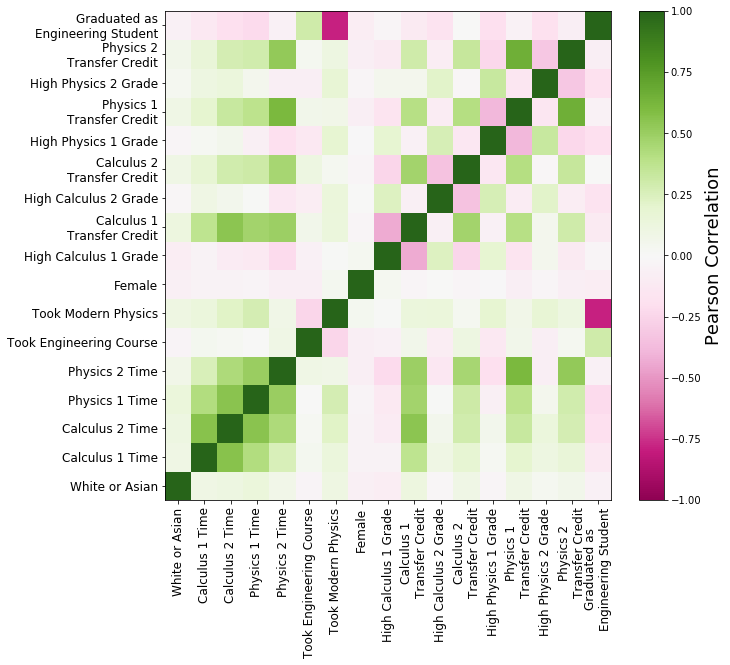

In [27]:
feat = ['ethnicity', 'calc1_time', 'calc2_time', 'phys1_time', 'phys2_time',
       'took_engineering_course_as_physics_major', 'took_phy215', 'gender_F',
       'calc1_grade_high', 
       'calc1_grade_transfer', 'calc2_grade_high',
       'calc2_grade_transfer', 'phys1_grade_high', 
       'phys1_grade_transfer', 'phys2_grade_high', 
       'phys2_grade_transfer', 'pred_n']

labels = ['ethnicity', 'calc1_time', 'calc2_time', 'phys1_time', 'phys2_time',
       'took engineering course\nas physics major', 'took modern physics', 'gender_F',
       'calc1_grade_high', 'calc1_grade_transfer', 'calc2_grade_high',
       'calc2_grade_transfer', 'phys1_grade_high', 'phys1_grade_transfer',
       'phys2_grade_high', 'phys2_grade_transfer', 'pred_n']

corr_data = model_data[feat].corr()

fig, ax = plt.subplots(figsize=(10, 9))

x = np.arange(0, corr_data.shape[1]+1, 1)
y = np.arange(0, corr_data.shape[0]+1, 1)

xx, yy = np.meshgrid(x, y)
z = corr_data.values
cbar = ax.pcolormesh(xx, yy, z, cmap='PiYG', vmin=-1, vmax=1)
fig.colorbar(cbar, label='Pearson Correlation').set_label(label='Pearson Correlation', fontsize=18)

ax.set_xticks(x+0.5)
# ax.set_xticklabels(corr_data.columns, rotation=90)
ax.set_xticklabels(labels, rotation=90, fontsize=12)
ax.set_yticks(y+0.5)
# ax.set_yticklabels(corr_data.index, rotation=0)
ax.set_yticklabels(labels, rotation=0, fontsize=12)

ax.set_ylim(0, y.max())
ax.set_xlim(0, x.max())

labels = ['White or Asian', 'Calculus 1 Time', 'Calculus 2 Time', 'Physics 1 Time', 'Physics 2 Time', 'Took Engineering Course', 'Took Modern Physics', 'Female', 'High Calculus 1 Grade', 'Calculus 1\nTransfer Credit', 'High Calculus 2 Grade', 'Calculus 2\nTransfer Credit', 'High Physics 1 Grade', 'Physics 1\nTransfer Credit', 'High Physics 2 Grade', 'Physics 2\nTransfer Credit', 'Graduated as\nEngineering Student']

ax.set_yticklabels(labels)
ax.set_xticklabels(labels)


fig.savefig('figures/corrplot.pdf', bbox_inches='tight')

In [28]:
corr_data.index

Index(['ethnicity', 'calc1_time', 'calc2_time', 'phys1_time', 'phys2_time',
       'took_engineering_course_as_physics_major', 'took_phy215', 'gender_F',
       'calc1_grade_high', 'calc1_grade_transfer', 'calc2_grade_high',
       'calc2_grade_transfer', 'phys1_grade_high', 'phys1_grade_transfer',
       'phys2_grade_high', 'phys2_grade_transfer', 'pred_n'],
      dtype='object')

In [29]:
corr_data

,ethnicity,calc1_time,calc2_time,phys1_time,phys2_time,took_engineering_course_as_physics_major,took_phy215,gender_F,calc1_grade_high,calc1_grade_transfer,calc2_grade_high,calc2_grade_transfer,phys1_grade_high,phys1_grade_transfer,phys2_grade_high,phys2_grade_transfer,pred_n
ethnicity,1.000000,0.095987,0.117104,0.142638,0.071916,-0.037991,0.104350,-0.066401,-0.091868,0.121115,-0.020288,0.091030,-0.028615,0.087807,0.035895,0.067859,-0.061554
calc1_time,0.095987,1.000000,0.565856,0.420284,0.260564,0.045055,0.137604,-0.042030,-0.042255,0.372630,0.094626,0.185052,0.026810,0.196291,0.115473,0.162123,-0.130873
calc2_time,0.117104,0.565856,1.000000,0.557776,0.436756,0.029139,0.219439,-0.044542,-0.101783,0.551198,0.057477,0.292385,0.060593,0.334838,0.133174,0.279742,-0.196240
phys1_time,0.142638,0.420284,0.557776,1.000000,0.506514,0.003899,0.276221,-0.034027,-0.123251,0.470128,0.008601,0.310369,-0.065318,0.375709,0.048482,0.293411,-0.224632
phys2_time,0.071916,0.260564,0.436756,0.506514,1.000000,0.093501,0.082630,-0.070894,-0.222516,0.499668,-0.135434,0.459595,-0.197851,0.616537,-0.082513,0.523583,-0.059144
took_engineering_course_as_physics_major,-0.037991,0.045055,0.029139,0.003899,0.093501,1.000000,-0.243683,-0.071701,-0.061202,0.067454,-0.086219,0.111733,-0.125191,0.062651,-0.076764,0.031429,0.298711
took_phy215,0.104350,0.137604,0.219439,0.276221,0.082630,-0.243683,1.000000,0.043973,0.012250,0.133653,0.144754,0.038101,0.188454,0.076054,0.172499,0.115941,-0.783860
gender_F,-0.066401,-0.042030,-0.044542,-0.034027,-0.070894,-0.071701,0.043973,1.000000,0.036501,-0.030702,0.005722,-0.028834,-0.010412,-0.071656,-0.028386,-0.074359,-0.086913
calc1_grade_high,-0.091868,-0.042255,-0.101783,-0.123251,-0.222516,-0.061202,0.012250,0.036501,1.000000,-0.432260,0.240329,-0.248706,0.188409,-0.167516,0.052312,-0.109815,-0.023713
calc1_grade_transfer,0.121115,0.372630,0.551198,0.470128,0.499668,0.067454,0.133653,-0.030702,-0.432260,1.000000,-0.069436,0.471641,-0.062059,0.402571,0.053610,0.298191,-0.109570


In [33]:
train_x, test_x, train_y, test_y = train_test_split(model_data[features], model_data['pred_n'], train_size=0.7, test_size=0.3, random_state=random_state)

In [34]:
print('fraction of test data in each class')
test_y.reset_index().groupby('pred_n').count()/test_y.count()

fraction of test data in each class


,student_id_fk
pred_n,
0,0.456674
1,0.543326


In [35]:
print('fraction of train data in each class')
train_y.reset_index().groupby('pred_n').count()/train_y.count()

fraction of train data in each class


,student_id_fk
pred_n,
0,0.473367
1,0.526633


In [36]:
params = {
    'max_depth':[2, 3, 4]
    ,'n_estimators':[400, 450, 500, 550, 600]
    ,'max_features':[4, 5, 6, 7]
    ,'min_samples_split':[15, 20, 25, 30]
    ,'min_samples_leaf':[1, 3, 10]
    ,'criterion':['gini', 'entropy']
    ,'random_state':[random_state]
}

clf = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(clf, param_grid=params, n_jobs=-1)
grid_search.fit(train_x, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4], 'n_estimators': [400, 450, 500, 550, 600], 'max_features': [4, 5, 6, 7], 'min_samples_split': [15, 20, 25, 30], 'min_samples_leaf': [1, 3, 10], 'criterion': ['gini', 'entropy'], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
clf = grid_search.best_estimator_
clf.fit(train_x, train_y)
print('accuracy:', clf.score(test_x, test_y))

predictions = clf.predict(test_x)
cm = metrics.confusion_matrix(test_y, predictions)
print('confusion matrix:\n', cm)
print('confusion matrix fractions:\n', cm/cm.sum())
predict_prob = clf.predict_proba(test_x)

rocdf = pd.DataFrame({'test_true':test_y})
rocdf['test_pred'] = predictions#rocdf.apply(lambda row: 1 if row['test']=='Physics-Astronomy' else 0, axis=1)
fpr, tpr, thresholds = metrics.roc_curve(rocdf['test_true'], predict_prob[:,1])

auc = metrics.roc_auc_score(rocdf['test_true'], predict_prob[:,1])
print('auc:', auc)

joblib.dump(clf, 'gscv_rf_engineering.pkl') 

accuracy: 0.901639344262
confusion matrix:
 [[177  18]
 [ 24 208]]
confusion matrix fractions:
 [[ 0.41451991  0.04215457]
 [ 0.05620609  0.48711944]]
auc: 0.933930150309


['gscv_rf_engineering.pkl']

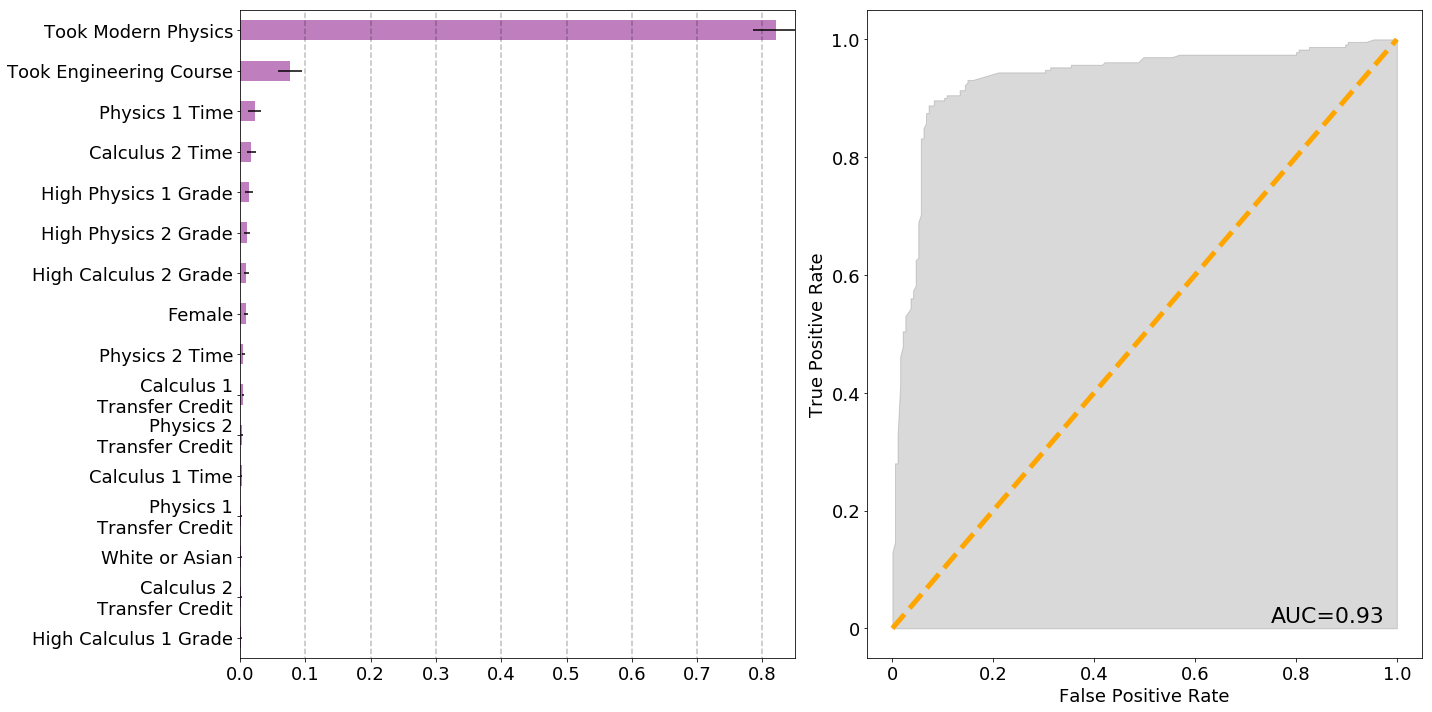

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[1].fill_between(fpr, 0, tpr, color='black', alpha=0.15)
    
ax[1].plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=5, zorder=1)
ax[1].set_ylabel('True Positive Rate', fontsize=18)
ax[1].set_xlabel('False Positive Rate', fontsize=18)

ax[1].text(s='AUC={auc}'.format(auc=round(auc, 2)), x= 0.751, y=0.01, fontsize=22)

ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(ticks, fontsize=18)
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks, fontsize=18)


index = [
    'White or Asian'
        ,'Calculus 1 Time'
    ,'Calculus 2 Time'
    ,'Physics 1 Time'
    ,'Physics 2 Time'
    ,'Took Engineering Course'
    ,'Took Modern Physics'
    ,'Female'
    ,'High Calculus 1 Grade'
    ,'Calculus 1\nTransfer Credit'
    ,'High Calculus 2 Grade'
    ,'Calculus 2\nTransfer Credit'
    ,'High Physics 1 Grade'
    ,'Physics 1\nTransfer Credit'
    ,'High Physics 2 Grade'
    ,'Physics 2\nTransfer Credit'
]

rf_features = pd.DataFrame({'feature importances':clf.feature_importances_}, index=index)
rf_features['error'] = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)/np.sqrt(16)

rf_features.sort_values(by='feature importances').plot.barh(ax=ax[0], legend=False, color='Purple', xerr='error', alpha=0.5)
# ax[0].set_yticklabels(ylabels, fontsize=18)

for x in np.arange(0.1, 1, 0.1):
    ax[0].plot([x, x], [-1, 17], linestyle='--', color='black', alpha=0.25)

ax[0].set_xticks(np.arange(0, 1, 0.1))
ax[0].set_xticklabels(np.arange(0, 1, 0.1), fontsize=18)

ax[0].set_xlim(0, 0.85)


labels = [ 'White or Asian', 'Physics 1\nTransfer Credit', 'Calculus 2\nTransfer Credit', 'Calculus 1 Time', 'Physics 2 Time', 'Calculus 2 Time', 'Physics 1 Time', 'Took Engineering Course', 'Took Modern Physics', 'Female',  'Calculus 1\nTransfer Credit', 'High Calculus 2 Grade',  'High Physics 1 Grade',  'High Physics 2 Grade', 'Physics 2\nTransfer Credit', 'Graduated as\nEngineering Student']
plt.setp(ax[0].get_yticklabels(), fontsize=18)

fig.tight_layout()

fig.savefig('figures/featimportance_auc.pdf', bbox_inches='tight')

In [55]:
[x.replace('_', ' ') for x in rf_features.sort_values(by='feature importances').index]

['High Calculus 1 Grade',
 'Calculus 2\nTransfer Credit',
 'White or Asian',
 'Physics 1\nTransfer Credit',
 'Calculus 1 Time',
 'Physics 2\nTransfer Credit',
 'Calculus 1\nTransfer Credit',
 'Physics 2 Time',
 'Female',
 'High Calculus 2 Grade',
 'High Physics 2 Grade',
 'High Physics 1 Grade',
 'Calculus 2 Time',
 'Physics 1 Time',
 'Took Engineering Course',
 'Took Modern Physics']

In [56]:
# The Recursive feature elimination class fails to use the grid search estimator 
# so we rebuild the estimator using the same parameters as the best estimator

rf_params = clf.get_params()
rf_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 7,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [57]:
rf = RandomForestClassifier(bootstrap=rf_params['bootstrap']
                           ,class_weight=rf_params['class_weight']
                           ,criterion=rf_params['criterion']
                           ,max_depth=rf_params['max_depth']
                           ,max_leaf_nodes=rf_params['max_leaf_nodes']
                           ,min_impurity_decrease=rf_params['min_impurity_decrease']
                           ,min_impurity_split=rf_params['min_impurity_split']
                           ,min_samples_leaf=rf_params['min_samples_leaf']
                           ,min_samples_split=rf_params['min_samples_split']
                           ,min_weight_fraction_leaf=rf_params['min_weight_fraction_leaf']
                           ,n_estimators=rf_params['n_estimators']
                           ,n_jobs=rf_params['n_jobs']
                           ,oob_score=rf_params['oob_score']
                           ,random_state=rf_params['random_state']
                           ,verbose=rf_params['verbose']
                           ,warm_start=rf_params['warm_start'])

In [58]:
x = model_data[features]
y = model_data['pred_n']
rfecv_auc = RFECV(estimator=rf, step=1, cv=3, scoring='roc_auc', verbose=0, n_jobs=-1)
selector=rfecv_auc.fit(x, y)

rfecv_acc = RFECV(estimator=rf, step=1, cv=3, scoring='accuracy', verbose=0, n_jobs=-1)
selector=rfecv_acc.fit(x, y)

In [59]:
rfecv_results = pd.DataFrame({'ranking (AUC)':rfecv_auc.ranking_, 'ranking (ACC)':rfecv_acc.ranking_, 'AUC':rfecv_auc.grid_scores_, 'accuracy':rfecv_acc.grid_scores_}, index=features)
rfecv_results.sort_values(by='ranking (ACC)')

,ranking (AUC),ranking (ACC),AUC,accuracy
phys1_time,1,1,0.915302,0.890295
took_engineering_course_as_physics_major,1,1,0.924377,0.888186
took_phy215,1,1,0.927284,0.887482
phys1_grade_high,1,2,0.928828,0.890999
calc2_time,1,3,0.913971,0.892405
phys2_grade_high,1,4,0.927693,0.888186
calc2_grade_high,1,5,0.927675,0.890295
gender_F,1,6,0.928428,0.886779
phys2_time,1,7,0.920230,0.890999
phys2_grade_transfer,1,8,0.928425,0.888889


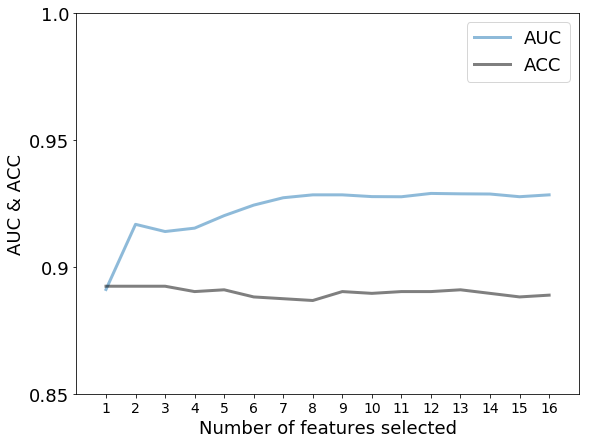

In [60]:
fig, ax = plt.subplots(figsize=(9, 7))

x = np.arange(1, rfecv_results.shape[0]+1)

ax.plot(x, rfecv_auc.grid_scores_, linewidth=3, alpha=0.5, label='AUC')
ax.set_xticks(np.arange(0,22,1).astype(int))
ax.set_ylim(0.85, 1)

ax.set_xlim(0, 17)

ax.set_xlabel("Number of features selected", fontsize=18)
ax.set_ylabel("AUC & ACC", fontsize=18)

ax.plot(x, rfecv_acc.grid_scores_, color='black', linewidth=3, alpha=0.5, label='ACC')

ax.legend(fontsize=18)

ax.set_yticks([0.85, 0.9, 0.95, 1.0])
ax.set_yticklabels([0.85, 0.9, 0.95, 1.0], fontsize=18)

ax.set_xticks(np.arange(1, 17, 1))
ax.set_xticklabels(np.arange(1, 17, 1), fontsize=14)

fig.savefig('figures/aucacc.pdf', bbox_inches='tight')

In [61]:
clf = grid_search.best_estimator_
# model_data = df.set_index('student_id_fk')[['enroll_date', 'grad_date']].join(model_data, rsuffix='_r', how='right')
model_data_copy = df.set_index('student_id_fk')[['enroll_date', 'grad_date']].join(model_data, rsuffix='_r', how='right').copy()
window_halfsize = 3

lower_year = 1993 +window_halfsize
upper_year = 2014
years = np.arange(lower_year, upper_year, 1)

paramters_for_pool = lower_year, upper_year

feature_df = pd.DataFrame()
error_df = pd.DataFrame()

enrolled_df = pd.DataFrame()

for n, y in enumerate(years):
    
    lower_year = y - window_halfsize
    upper_year = y + window_halfsize
    
    window_df = model_data_copy[model_data_copy.enroll_date.between(str(lower_year), str(upper_year))].copy()
    
    enroll_data = {}
    enroll_data['physics'] = window_df.groupby('pred_n').count()[['enroll_date']].loc[0].values
    enroll_data['engineers'] = window_df.groupby('pred_n').count()[['enroll_date']].loc[1].values
    
    edf = pd.DataFrame(enroll_data, index=[y])
    
    enrolled_df = pd.concat([enrolled_df, edf])
    
    count = window_df.shape[0]
    
#     train_x, test_x, train_y, test_y = train_test_split(window_df[features], window_df['pred_n'], train_size=0.7)
    train_x, test_x, train_y, test_y = train_test_split(window_df[features], window_df['pred_n'], train_size=0.7, test_size=0.3, random_state=random_state)
    
    clf.fit(train_x, train_y)
    
    ACC = clf.score(test_x, test_y)
    
    data = {}
    error = {}
#     for f, fi in zip(features, grid_search.best_estimator_.feature_importances_):
    for f, fi in zip(features, clf.feature_importances_):
        data[f] = fi
        
    errz = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)/np.sqrt(16)
    for f, e in zip(features, errz):
        error[f] = e
        
    error['window_center'] = y
    
    data['ACC'] = ACC
    data['window_center'] = y
    data['count'] = count
    

    year_df = pd.DataFrame(data, index=[y])
    
    year_error_df = pd.DataFrame(error, index=[y])
    
    feature_df = pd.concat([feature_df, year_df])
    error_df = pd.concat([error_df, year_error_df])

In [62]:
feature_df.head()

,ethnicity,calc1_time,calc2_time,phys1_time,phys2_time,took_engineering_course_as_physics_major,took_phy215,gender_F,calc1_grade_high,calc1_grade_transfer,calc2_grade_high,calc2_grade_transfer,phys1_grade_high,phys1_grade_transfer,phys2_grade_high,phys2_grade_transfer,ACC,window_center,count
1996,0.014353,0.032540,0.013620,0.081893,0.028355,0.077784,0.600618,0.023052,0.014849,0.007213,0.017186,0.021560,0.025506,0.005016,0.032210,0.004246,0.902778,1996,240
1997,0.010020,0.017737,0.009292,0.048064,0.011345,0.035210,0.727105,0.038080,0.005638,0.003674,0.024324,0.006528,0.024790,0.006911,0.017245,0.014037,0.842105,1997,251
1998,0.004992,0.009625,0.008160,0.022126,0.007325,0.059436,0.747124,0.029223,0.010733,0.004411,0.017082,0.005129,0.056356,0.004209,0.011366,0.002701,0.843373,1998,274
1999,0.005501,0.005471,0.007899,0.036103,0.011345,0.042137,0.745799,0.011167,0.014825,0.005836,0.020203,0.023658,0.046940,0.006847,0.009832,0.006438,0.858696,1999,306
2000,0.007338,0.003039,0.005641,0.011919,0.013030,0.060873,0.755851,0.010377,0.001880,0.003609,0.019177,0.012700,0.076929,0.004198,0.011716,0.001723,0.885714,2000,349


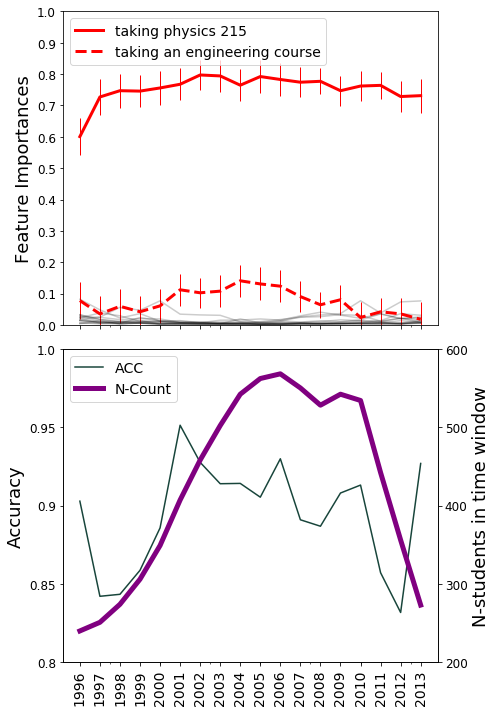

In [63]:
features_subset = ['ethnicity', 'calc1_time', 'calc2_time', 'phys1_time', 'phys2_time','gender_F',
       'calc1_grade_high', 'calc1_grade_transfer', 'calc2_grade_high',
       'calc2_grade_transfer', 'phys1_grade_high', 'phys1_grade_transfer',
       'phys2_grade_high', 'phys2_grade_transfer',]


fig, ax = plt.subplots(2, 1, figsize=(7, 10), sharex=True)

# ax[0].plot(feature_df.index, feature_df['took_phy215'].values, color='red')
# ax[0].plot(feature_df.index, feature_df['took_engineering_course_as_physics_major'].values, color='red', linestyle='--')

ax[0].plot([],[], color='red', linewidth=3, linestyle='-')
ax[0].plot([],[], color='red', linewidth=3, linestyle='--')
ax[0].legend(['taking physics 215', 'taking an engineering course'], fontsize=14, loc='upper left')


ax[0].errorbar(feature_df.index, feature_df['took_phy215'].values, error_df['took_phy215'], color='red'
              , linewidth=3, elinewidth=1)
ax[0].errorbar(feature_df.index, feature_df['took_engineering_course_as_physics_major'].values
               , error_df['took_phy215'], color='red', linestyle='--', linewidth=3, elinewidth=1)



for f in features_subset:
    ax[0].plot(feature_df.index, feature_df[f].values, color='black', alpha=0.2)
#     ax[0].errorbar(error_df.index, feature_df[f].values, error_df[f].values, alpha=0.2, color='black')

ax[0].set_xticks(feature_df.index)   
ax[0].set_xticklabels(feature_df.index, rotation=90, fontsize=12)
ax[0].set_yticks(np.arange(0, 1.01, 0.1))
ax[0].set_yticklabels(np.arange(0, 1.01, 0.1), fontsize=12)
ax[0].set_ylim(0, 1)

feature_df['ACC'].plot(ax=ax[1], color='#18453b')
ax[1].set_ylim(0.8, 1)
ax[1].set_xticks(feature_df.index)   
ax[1].set_xticklabels(feature_df.index, rotation=90, fontsize=14)
ax[1].set_yticks(np.arange(0.8, 1.025, 0.05))
ax[1].set_yticklabels(np.arange(0.8, 1.025, 0.05), fontsize=12)

ax3 = ax[1].twinx()

feature_df['count'].plot(ax=ax3, color='Purple', linewidth=5)
ax3.set_ylim(200, 600)
ax3.set_xticks(feature_df.index)   
ax3.set_xticklabels(feature_df.index, rotation=90, fontsize=18)
ax3.set_yticks(np.arange(200, 601, 100))
ax3.set_yticklabels(np.arange(200, 601, 100), fontsize=12)

ax[0].set_ylabel('Feature Importances', fontsize=18)
ax[1].set_ylabel('Accuracy', fontsize=18)
ax3.set_ylabel('N-students in time window', fontsize=18)

ax[1].plot([],[], label='N-Count', color='Purple', linewidth=5)
ax[1].legend(fontsize=14, loc='upper left')

fig.tight_layout()

fig.savefig('figures/feat_over_time.pdf', bbox_inches='tight')

In [64]:
feature_df[feature_df > 0.1]

,ethnicity,calc1_time,calc2_time,phys1_time,phys2_time,took_engineering_course_as_physics_major,took_phy215,gender_F,calc1_grade_high,calc1_grade_transfer,calc2_grade_high,calc2_grade_transfer,phys1_grade_high,phys1_grade_transfer,phys2_grade_high,phys2_grade_transfer,ACC,window_center,count
1996,NaN,NaN,NaN,NaN,NaN,NaN,0.600618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.902778,1996,240
1997,NaN,NaN,NaN,NaN,NaN,NaN,0.727105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.842105,1997,251
1998,NaN,NaN,NaN,NaN,NaN,NaN,0.747124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.843373,1998,274
1999,NaN,NaN,NaN,NaN,NaN,NaN,0.745799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.858696,1999,306
2000,NaN,NaN,NaN,NaN,NaN,NaN,0.755851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.885714,2000,349
2001,NaN,NaN,NaN,NaN,NaN,0.112153,0.767598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.951220,2001,407
2002,NaN,NaN,NaN,NaN,NaN,0.102526,0.797242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.927536,2002,458
2003,NaN,NaN,NaN,NaN,NaN,0.107799,0.794230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.913907,2003,502
2004,NaN,NaN,NaN,NaN,NaN,0.140840,0.764615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914110,2004,542
2005,NaN,NaN,NaN,NaN,NaN,0.130848,0.792231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905325,2005,562


In [65]:
df['grad_date'] = pd.to_datetime(df['grad_date'])
enroll_df = df[df['declared physics major']==1].groupby([pd.Grouper(key='grad_date', freq='1y'), 'pred_category']).count()[['student_id_fk']].reset_index().pivot_table(index='grad_date', columns='pred_category', values='student_id_fk')
enroll_df.columns = ['engineering', 'physics']
enroll_df['total'] = enroll_df.sum(axis=1)
enroll_df['engineering percent'] = enroll_df['engineering']/enroll_df['total']
enroll_df['physics percent'] = enroll_df['physics']/enroll_df['total']

In [66]:
enroll_df

,engineering,physics,total,engineering percent,physics percent
grad_date,,,,,
1994-12-31,1,1,2,0.500000,0.500000
1996-12-31,5,4,9,0.555556,0.444444
1997-12-31,10,12,22,0.454545,0.545455
1998-12-31,11,14,25,0.440000,0.560000
1999-12-31,26,11,37,0.702703,0.297297
2000-12-31,23,16,39,0.589744,0.410256
2001-12-31,12,20,32,0.375000,0.625000
2002-12-31,25,20,45,0.555556,0.444444
2003-12-31,23,26,49,0.469388,0.530612


In [67]:
counts = pd.DataFrame({'pre (1993-2005)':enroll_df.iloc[:11].sum(), 'during (2005-2011)':enroll_df[11:17].sum(), 'after (2011-present)':enroll_df[17:].sum()}).loc[['engineering', 'physics']].transpose()
stats.chi2_contingency(counts.values)

(2.6616436522602092,
 0.26425999626493907,
 2,
 array([[ 207.87341772,  183.12658228],
        [ 291.34177215,  256.65822785],
        [ 256.78481013,  226.21518987]]))

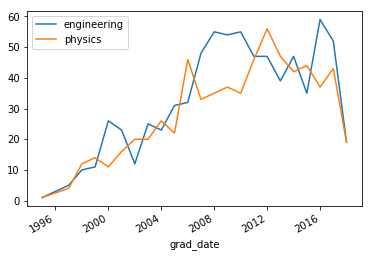

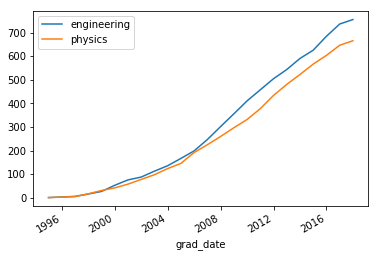

In [68]:
### fig, ax = plt.subplots()

enroll_df[['engineering', 'physics']].plot()
enroll_df[['engineering', 'physics']].cumsum().plot()

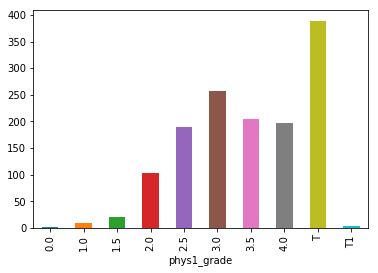

In [69]:
df[df['declared physics major']==1].groupby(['phys1_grade']).count().iloc[0:10]['student_id_fk'].plot.bar()